In [1]:
from dataset import AirQualityDatasetV2, AirQualityDataModuleV2
from hydra import initialize, compose
import os
import torch
from torch import nn
import torch.nn.functional as F
with initialize(version_base=None, config_path=os.path.relpath("/home/hoang/Documents/CodeSpace/air-quality-forecasting/config")):
  cfg = compose(config_name="daqff.yaml")

/home/hoang/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dtm = AirQualityDataModuleV2(
        "../data",
        # normalize_mean={"humidity":0, "temperature": 0, "PM2.5": 0},
        # normalize_std={"humidity": 1, "temperature": 1, "PM2.5": 1},
        normalize_mean=cfg.data.normalize_mean,
        normalize_std=cfg.data.normalize_std,
        droprate=0.5,
        split_mode="timestamp",
        fillnan_fn=lambda x: x.interpolate(option="spline").bfill(),
        train_ratio=0.75,
        batch_size=1
    )
dtm.setup()

In [21]:
from utils.functional import scale_softmax
from tqdm import tqdm


class SpatialModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.linear = nn.Linear(2, 32)
        self.linear2 = nn.Linear(32, 1)
    
    def forward(
        self,
        srcs: torch.Tensor,
        src_locs: torch.Tensor,
        tar_loc: torch.Tensor,
        src_masks: torch.Tensor
    ):
        assert srcs.size(0) == 1
        # src_locs.shape == (n_stations, 2)
        # tar_loc.shape == (2,)
        # src_locs.shape == (n_stations, 24)

        src_masks = src_masks.squeeze(-1)
        src_locs = src_locs.squeeze(-1)[src_masks]
        srcs = srcs.squeeze(-1)[src_masks]

        loc_mean_ = srcs.new_tensor([105.6796,  20.9672])
        loc_std_ = srcs.new_tensor([0.1794, 0.0830])

        locs = torch.cat((src_locs, tar_loc))
        # norm locs
        locs = (locs - loc_mean_) / loc_std_
        # (n_st, 32)
        geo_feats = self.linear(locs)

        src_feats = geo_feats[:-1].contiguous()
        tar_feats = geo_feats[-1].contiguous().unsqueeze(0)

        # weights = torch.matmul(src_feats, tar_feats.t())
        weights = (src_feats - tar_feats).abs().pow(-2)
        weights = weights / weights.sum(0)
        # weights = torch.softmax(weights, dim=0)
        weights = torch.softmax(self.linear2(weights), dim=0)

        # print(weights)

        # print(srcs.shape, weights.shape)

        preds = (srcs * weights).sum(0)

        return preds
    
    def compute_loss(self, input, target):
        loss = (input - target).pow(2).mean().sqrt()

        return loss

    def fit(self, train_dataloader, val_dataloader, n_epochs: int):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        criterion = self.compute_loss

        metrics = []

        for _ in range(n_epochs):
            with tqdm(train_dataloader, leave=False) as bar:
                rloss = []
                for batch_idx, batch in enumerate(bar):
                    output = self(batch["src_nexts"], batch["src_locs"], batch["tar_loc"], batch["src_masks"])

                    loss = criterion(output, batch["target"].squeeze(0))

                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                    rloss.append(loss.item())

                    if batch_idx % 100 == 0:
                        avgl = sum(rloss) / len(rloss)
                        bar.set_postfix(loss=avgl)
                        rloss.clear()
                bar.refresh()
                bar.reset()

            with tqdm(val_dataloader) as bar:
                self.eval()
                with torch.no_grad():
                    rmetr = []
                    for batch_idx, batch in enumerate(bar):
                        output = self(batch["src_nexts"], batch["src_locs"], batch["tar_loc"], batch["src_masks"])

                        output = output * cfg.data.normalize_std["PM2.5"] + cfg.data.normalize_mean["PM2.5"]
                        mae = (output - batch["gt_target"]).abs().mean().item()

                        rmetr.append(mae)
                    metrics.append(sum(rmetr) / len(rmetr))
                    rmetr.clear()

                self.train(True)

        return metrics

In [22]:
model = SpatialModel()

In [23]:
log = model.fit(dtm.train_dataloader(), dtm.val_dataloader(), n_epochs=5)

100%|██████████| 359/359 [00:03<00:00, 115.47it/s]               


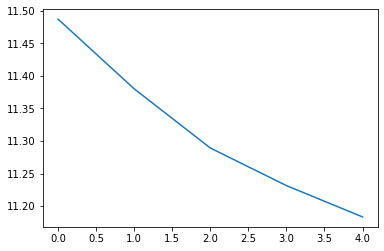

In [24]:
import matplotlib.pyplot as plt
plt.plot(log)